In [11]:
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from transformers import BertTokenizer, BertModel, get_linear_schedule_with_warmup

from data_loader import *
from modeling import *
from training import *
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

In [2]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
RANDOM_SEED = 42


df = pd.read_csv("data/sentiment.csv")
map_sentiment = { 'Negative': 0, 'Positive': 1}
class_names = ['Negative', 'Positive']
df.rename(columns={'Tweet Text': 'news'}, inplace=True)  # change the description name to new

df['labels'] = df['Sentiment'].map(map_sentiment)

print(df.columns)
print(df.labels.value_counts())

Index(['Stock Ticker', 'news', 'Sentiment', 'Tweet URL', 'labels'], dtype='object')
labels
1    327
0    173
Name: count, dtype: int64


In [3]:
df_train, df_test = train_test_split(df, test_size = 0.3, random_state = RANDOM_SEED)

df_val, df_test = train_test_split(df_test, test_size = 0.5, random_state = RANDOM_SEED)

In [4]:

from transformers import BertTokenizer, BertForSequenceClassification
#finbert -> ProsusAI/finbert
finbert = BertForSequenceClassification.from_pretrained('ProsusAI/finbert',num_labels=3)
tokenizer = BertTokenizer.from_pretrained('ProsusAI/finbert')

In [5]:

max_len = 128 # change accordingly
batch_size = 16 # change accordingly

train_data_loader = create_data_loader(df_train, tokenizer, max_len, batch_size)
val_data_loader = create_data_loader(df_val, tokenizer, max_len, batch_size, include_raw_text=False)
test_data_loader = create_data_loader(df_test, tokenizer,max_len, batch_size, include_raw_text=False)

print(df_train.shape, df_val.shape, df_test.shape)

(350, 5) (75, 5) (75, 5)


In [6]:
finbert_fine_tune = SentimentClassifier(2, "ProsusAI/finbert", model_name= "finbert-fine-tune", do_fine_tune = True).to(device)

finbert_base = SentimentClassifier(2, "ProsusAI/finbert", model_name = "finber-base", do_fine_tune = False).to(device)

In [7]:
df_train, df_test = train_test_split(df, test_size = 0.3, random_state = RANDOM_SEED)

df_val, df_test = train_test_split(df_test, test_size = 0.5, random_state = RANDOM_SEED)

In [8]:

max_len = 128 # change accordingly
batch_size = 16 # change accordingly

train_data_loader = create_data_loader(df_train, tokenizer, max_len, batch_size)
val_data_loader = create_data_loader(df_val, tokenizer, max_len, batch_size)
test_data_loader = create_data_loader(df_test, tokenizer,max_len, batch_size)

print(df_train.shape, df_val.shape, df_test.shape)

(350, 5) (75, 5) (75, 5)


In [9]:
EPOCHS = 3

optimizer = optim.AdamW(finbert_fine_tune.parameters(), lr= 2e-5)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps = 0, 
    num_training_steps=total_steps)

loss_fn = nn.CrossEntropyLoss().to(device)

In [10]:
EPOCHS = 3

optimizer_base = optim.AdamW(finbert_base.parameters(), lr= 2e-5)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer_base, 
    num_warmup_steps = 0, 
    num_training_steps=total_steps)

loss_fn = nn.CrossEntropyLoss().to(device)

## fine tuned finbert
burada finbert in yiyanghkust/finbert-tone modelini kullanmisim
ProsusAI/finbert ile calistirmadim


In [12]:
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/ {EPOCHS}')
    print('-'*15)
    train_acc, train_loss = train_model(finbert_fine_tune, train_data_loader, loss_fn, optimizer, device, scheduler, len(df_train))
    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(finbert_fine_tune, val_data_loader, loss_fn, device, len(df_val))
    print(f'Val loss {val_loss} accuracy {val_acc}')

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
  
    if val_acc>best_accuracy:
        torch.save(finbert_fine_tune.state_dict(), './saved_models/{}.bin'.format(finbert_fine_tune.model_name)) # check this
        best_accuracy = val_acc

Epoch 1/ 3
---------------
Train loss 0.6485979990525679 accuracy 0.6200000047683716
Val loss 0.4647055685520172 accuracy 0.8266666531562805
Epoch 2/ 3
---------------
Train loss 0.4863403778184544 accuracy 0.8057143092155457
Val loss 0.4007686376571655 accuracy 0.8666666746139526
Epoch 3/ 3
---------------
Train loss 0.40054771168665454 accuracy 0.8600000143051147
Val loss 0.381109219789505 accuracy 0.8666666746139526


# base finbert

In [15]:
history_base = defaultdict(list)
best_accuracy_base = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/ {EPOCHS}')
    print('-'*15)
    train_acc, train_loss = train_model(finbert_base, train_data_loader, loss_fn, optimizer_base, device, scheduler, len(df_train))
    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(finbert_base, val_data_loader, loss_fn, device, len(df_val))
    print(f'Val loss {val_loss} accuracy {val_acc}')

    history_base['train_acc'].append(train_acc)
    history_base['train_loss'].append(train_loss)
    history_base['val_acc'].append(val_acc)
    history_base['val_loss'].append(val_loss)
  
    if val_acc>best_accuracy_base:
        torch.save(finbert_base.state_dict(), './saved_models/{}.bin'.format(finbert_base.model_name)
        best_accuracy_base = val_acc

Epoch 1/ 3
---------------
Train loss 0.7626371573318135 accuracy 0.46000000834465027
Val loss 0.7390401601791382 accuracy 0.46666666865348816
Epoch 2/ 3
---------------
Train loss 0.761683854189786 accuracy 0.4657142758369446
Val loss 0.7390401601791382 accuracy 0.46666666865348816
Epoch 3/ 3
---------------
Train loss 0.7634286988865245 accuracy 0.4571428596973419
Val loss 0.7390401601791382 accuracy 0.46666666865348816


              precision    recall  f1-score   support

    Negative       0.92      0.66      0.77        35
    Positive       0.76      0.95      0.84        40

    accuracy                           0.81        75
   macro avg       0.84      0.80      0.81        75
weighted avg       0.83      0.81      0.81        75



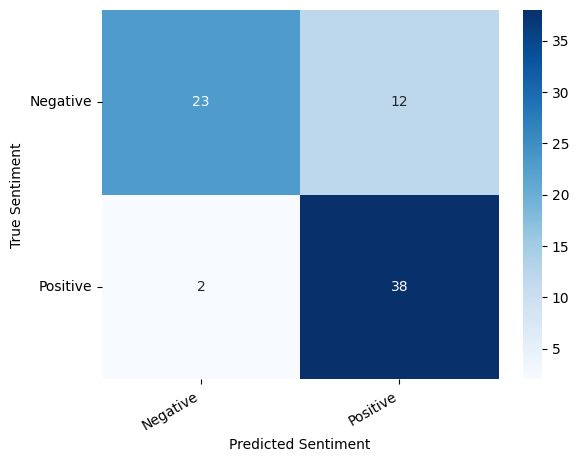

In [18]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation = 0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation = 30, ha='right')
    plt.ylabel('True Sentiment')
    plt.xlabel('Predicted Sentiment')
y_pred, y_pred_probs, y_test = get_predictions(finbert_fine_tune, test_data_loader)
print(classification_report(y_test, y_pred, target_names=class_names))

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns = class_names)
show_confusion_matrix(df_cm)

              precision    recall  f1-score   support

    Negative       0.15      0.09      0.11        35
    Positive       0.42      0.57      0.48        40

    accuracy                           0.35        75
   macro avg       0.28      0.33      0.30        75
weighted avg       0.29      0.35      0.31        75



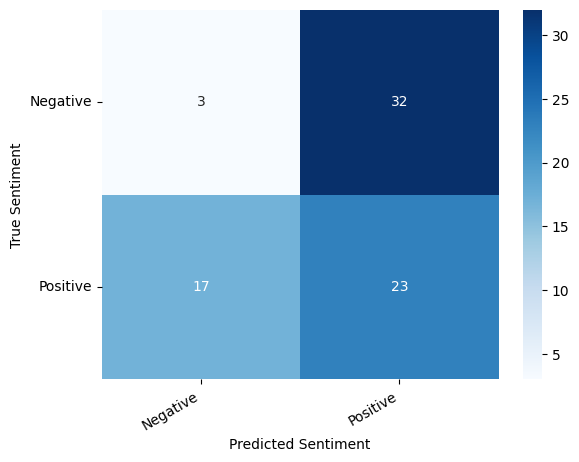

In [19]:
y_pred, y_pred_probs, y_test = get_predictions(finbert_base, test_data_loader)
print(classification_report(y_test, y_pred, target_names=class_names))

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns = class_names)
show_confusion_matrix(df_cm)